In [279]:
import sys
from pathlib import Path

ZORZIM_ROOT = Path("../..") if not "google.colab" in sys.modules else Path("aves_git")

EOD_PATH = ZORZIM_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('../../data/external/EOD_STGO')

In [280]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from aves.data import eod, census

from aves.visualization.tables import barchart

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 120
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [281]:
comunas = census.read_census_map('comuna', path=AVES_ROOT / "data" / "external" / "censo_2017_R13").to_crs('epsg:5361')
zones = gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json").set_index('ID').to_crs('epsg:5361')
zones["Comuna"].unique()

array(['El Bosque', 'San Bernardo', 'La Florida', 'Peñalolén',
       'Puente Alto', 'Pirque', 'La Pintana', 'La Granja', 'Maipú',
       'Cerrillos', 'Padre Hurtado', 'San Ramón', 'La Cisterna', 'Buin',
       'Calera de Tango', 'Talagante', 'El Monte', 'Isla de Maipo',
       'Peñaflor', 'Cerro Navia', 'Pudahuel', 'Renca', 'Quinta Normal',
       'Quilicura', 'Colina', 'Huechuraba', 'Lampa', 'Las Condes',
       'Providencia', 'La Reina', 'Lo Barnechea', 'Vitacura',
       'Independencia', 'Recoleta', 'Santiago', 'Pedro Aguirre Cerda',
       'San Miguel', 'Conchalí', 'San Joaquín', 'Lo Espejo',
       'Estación Central', 'Lo Prado', 'Ñuñoa', 'Macul'], dtype=object)

In [282]:
from aves.data import eod

viajes = eod.read_trips(EOD_PATH)
personas = eod.read_people(EOD_PATH)

In [283]:
viajes_input = viajes[["OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY", "HoraIni", "ModoAgregado"]]

viajes_por_persona = viajes[["Persona", "OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY", "HoraIni"]].set_index(["Persona"])
viajes_por_persona.index.unique()[2]

17344103

In [284]:
modes_dict = {"Caminata": ["Caminata"],
              "Red": ["Bus TS", "Bus TS - Metro", "Metro", "Otros - Bus TS", "Bus no TS - Metro",
                      "Taxi Colectivo - Metro", "Otros - Bus TS - Metro", "Auto - Metro",
                      "Bus TS - Bus no TS", "Otros - Metro", "Bus no TS"], 
                "Auto": ["Auto", "Taxi", "Taxi Colectivo"],
                "Otros": ["Otros"]
}

modes_dict2 = {}
 
# using loop to perform reverse mapping
for keys, vals in modes_dict.items(): 
   for val in vals: 
       modes_dict2[val] = keys

viajes2 = viajes_input.copy()

viajes2["ModoAgregado"] = viajes_input["ModoAgregado"].map(modes_dict2)

viajes2["ModoAgregado"].value_counts()

ModoAgregado
Red         38851
Auto        29958
Caminata    21267
Otros        5165
Name: count, dtype: int64

In [285]:
from sklearn.linear_model import LogisticRegression

class ModalSplitEstimator:
    lr: LogisticRegression()
    an: dict
    aninv: dict

    def __init__(self) -> None:
        self.lr = LogisticRegression(max_iter=10000, penalty="l2", solver="lbfgs", multi_class="multinomial", class_weight='balanced')
        self.an = {}
    
    def find_in_dict(self, x):
        return self.an[x]
    
    def fit(self, input_trips: pd.DataFrame) -> None:
        input_trips.dropna(inplace=True)
        input_trips.loc[:, "HoraIni"] = input_trips["HoraIni"].apply(lambda x: pd.to_timedelta(x)/pd.offsets.Minute(1))

        X = input_trips.drop(["ModoAgregado"], axis=1)
        y = input_trips["ModoAgregado"]
        self.lr.fit(X, y)

        for i in range(len(y)):
            self.an[y.iloc[i]] = i
        
        self.aninv =  { val: key for key, val in self.an.items() }

    def predict(self, samples):
        return self.lr.predict(samples)
        
    def predict_proba(self, samples):
        return self.lr.predict_proba(samples)
    
    def make_meshgrid(cmin, cmax, h=100):
        x_min, y_min = cmin[0], cmin[1]
        x_max, y_max = cmax[0], cmax[1]
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy
    
    def plot_origin_decision_boundary(self, ax: plt.Axes, cmin, cmax, dest, time, h=100, **params):

        xx, yy = self.make_meshgrid(cmin, cmax, h)

        xy = np.vstack([xx.ravel(), yy.ravel()]).transpose()

        plotgrid = pd.DataFrame(xy, columns=["OrigenCoordX", "OrigenCoordY"])
        plotgrid["DestinoCoordX"] = dest[0]
        plotgrid["DestinoCoordY"] = dest[1]
        plotgrid["HoraIni"] = time

        fv = np.vectorize(self.find_in_dict)

        Zs = self.lr.predict(plotgrid)
        Z = fv(Zs)
        Z = Z.reshape(xx.shape)

        out = ax.imshow(Z, extent=[cmin[0], cmax[0], cmin[1], cmax[1]], origin="upper", **params)
        return out
    
    def plot_destination_decision_boundary(self, ax: plt.Axes, cmin, cmax, orig, time, h=100, **params):

        xx, yy = self.make_meshgrid(cmin, cmax, h)

        xy = np.vstack([xx.ravel(), yy.ravel()]).transpose()

        plotgrid = pd.DataFrame(xy, columns=["DestinoCoordX", "DestinoCoordY"])
        plotgrid["OrigenCoordX"] = orig[0]
        plotgrid["OrigenCoordY"] = orig[1]
        plotgrid["HoraIni"] = time

        fv = np.vectorize(self.find_in_dict)

        Zs = self.lr.predict(plotgrid[["OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY", "HoraIni"]])
        Z = fv(Zs)
        Z = Z.reshape(xx.shape)

        out = ax.imshow(Z, extent=[cmin[0], cmin[1], cmax[0], cmax[1]], origin="upper", **params)
        return out

In [286]:
mse = ModalSplitEstimator()

mse.fit(viajes2)
samples = pd.DataFrame([[335208.7188, 6288387.0, 338812.3125, 6292391.0, 780.0]], columns=["OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY", "HoraIni"])
mse.predict(samples)

array(['Otros'], dtype=object)

In [287]:
bounding_box = zones.total_bounds

cmin = (bounding_box[0], bounding_box[1])
cmax = (bounding_box[2], bounding_box[3])

print(cmin)
print(cmax)

an = {"Red": 0, "Auto": 1,"Caminata": 2, "Otros":3}
aninv =  { val: key for key, val in an.items()  }
f = lambda x: an[x]
fv = np.vectorize(f)

def make_meshgrid(cmin, cmax, h=100):
    x_min, y_min = cmin[0], cmin[1]
    x_max, y_max = cmax[0], cmax[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):

    xy = np.vstack([xx.ravel(), yy.ravel()]).transpose()
    
    # -33.45790, -70.66452 en epsg:4326
    coords_universidad = (345307.03446438944, 6296709.302749639)

    # 8 am en minutos
    horainicio = 8.0 * 60.0

    plotgrid = pd.DataFrame(xy, columns=["OrigenCoordX", "OrigenCoordY"])
    plotgrid["DestinoCoordX"] = coords_universidad[0]
    plotgrid["DestinoCoordY"] = coords_universidad[1]
    plotgrid["HoraIni"] = horainicio

    Zs = clf.predict(plotgrid)
    Z = fv(Zs)
    Z = Z.reshape(xx.shape)

    print(Z)
    out = ax.imshow(Z, extent=[cmin[0], cmax[0], cmin[1], cmax[1]], origin="upper", **params)
    return out

(314984.4036820763, 6262284.197714263)
(365574.4686712656, 6328434.826860769)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]]


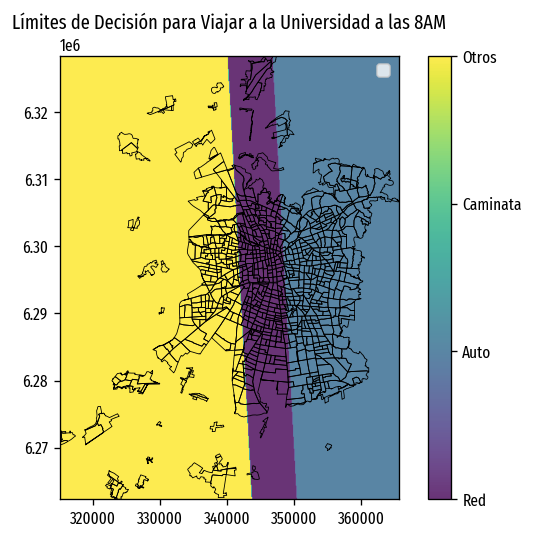

In [288]:
fig, ax = plt.subplots()
# title for the plots
title = ('Límites de Decisión para Viajar a la Universidad a las 8AM')
# Set-up grid for plotting.
X0, X1 = viajes_input["OrigenCoordX"], viajes_input["OrigenCoordY"]
xx, yy = make_meshgrid(cmin, cmax)

zones.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
im = plot_contours(ax, mse.lr, xx, yy, cmap="viridis", alpha=0.8)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(range(4))
cbar.set_ticklabels([aninv[t] for t in range(4)])
ax.set_title(title)
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]]
(662, 506)


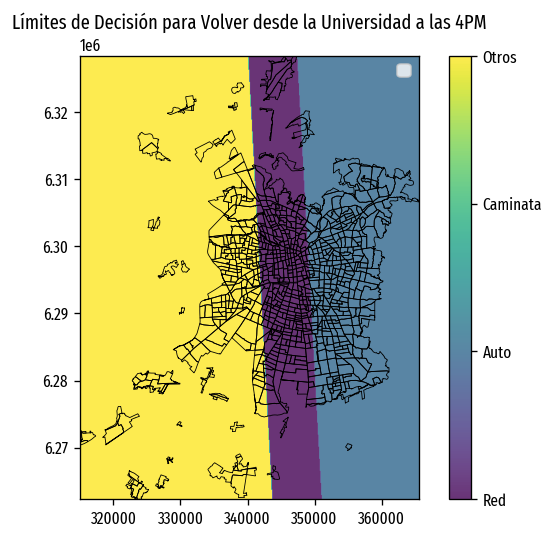

In [289]:

def plot_contours2(ax, clf, xx, yy, **params):

    xy = np.vstack([xx.ravel(), yy.ravel()]).transpose()
    
    # -33.45790, -70.66452 en epsg:4326
    coords_universidad = (345307.03446438944, 6296709.302749639)

    # 4pm en minutos
    horainicio = 16.0 * 60.0

    plotgrid = pd.DataFrame(xy, columns=["DestinoCoordX", "DestinoCoordY"])
    plotgrid["OrigenCoordX"] = coords_universidad[0]
    plotgrid["OrigenCoordY"] = coords_universidad[1]
    plotgrid["HoraIni"] = horainicio

    Zs = clf.predict(plotgrid[["OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY", "HoraIni"]])
    Z = fv(Zs)
    Z = Z.reshape(xx.shape)
    print(Z)
    print(Z.shape)
    out = ax.imshow(Z, extent=[cmin[0], cmax[0], cmin[1], cmax[1]], origin="upper", **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Límites de Decisión para Volver desde la Universidad a las 4PM')
# Set-up grid for plotting.
X0, X1 = viajes_input["OrigenCoordX"], viajes_input["OrigenCoordY"]
xx, yy = make_meshgrid(cmin, cmax)

zones.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
im = plot_contours2(ax, mse.lr, xx, yy, cmap="viridis", alpha=0.8)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(range(4))
cbar.set_ticklabels([aninv[t] for t in range(4)])
ax.set_title(title)
ax.legend()
plt.show()